# this is a massive amount of data for every recorded car crash in the US, with just about every bit of information you can imagine being tracked 

# there is alot we can do with this. I will do some initial EDA, but my overall passion for this is to find out just how dangerous motorcycles are by seeing how they contribute to the overall amount of deaths in these data

# as a statistician, I believe that it is important to understand the statistics behind the danger of motorcycles and spread that information to everyone who rides so that they are fully aware of the risk they take

# lets get started

In [1]:
import numpy as np
import pandas as pd
import math
import io
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as pt
import plotly.express as px
import os
import re
import statsmodels.api as sm
from bs4 import BeautifulSoup
import requests
import random, sys, time
from glob import glob
from pathlib import Path
import shutil
import openpyxl

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.style.use('ggplot')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', 1000)

# we will start with the accident dataset, as upon first inspection this looks like the file with the most information we will actually be interested in

In [4]:
try:
    df = pd.read_csv('/kaggle/input/fatal-motor-vehicle-crashes-2022-nhsta/FARS2022NationalCSV/accident.csv', encoding='ISO-8859-1')
    print("File read successfully with ISO-8859-1 encoding.")
except Exception as e:
    print("Error reading with ISO-8859-1:", e)

File read successfully with ISO-8859-1 encoding.


In [5]:
df.head(5)

,STATE,STATENAME,ST_CASE,PEDS,PERNOTMVIT,VE_TOTAL,VE_FORMS,PVH_INVL,PERSONS,PERMVIT,COUNTY,COUNTYNAME,CITY,CITYNAME,MONTH,MONTHNAME,DAY,DAYNAME,DAY_WEEK,DAY_WEEKNAME,YEAR,HOUR,HOURNAME,MINUTE,MINUTENAME,TWAY_ID,TWAY_ID2,ROUTE,ROUTENAME,RUR_URB,RUR_URBNAME,FUNC_SYS,FUNC_SYSNAME,RD_OWNER,RD_OWNERNAME,NHS,NHSNAME,SP_JUR,SP_JURNAME,MILEPT,MILEPTNAME,LATITUDE,LATITUDENAME,LONGITUD,LONGITUDNAME,HARM_EV,HARM_EVNAME,MAN_COLL,MAN_COLLNAME,RELJCT1,RELJCT1NAME,RELJCT2,RELJCT2NAME,TYP_INT,TYP_INTNAME,REL_ROAD,REL_ROADNAME,WRK_ZONE,WRK_ZONENAME,LGT_COND,LGT_CONDNAME,WEATHER,WEATHERNAME,SCH_BUS,SCH_BUSNAME,RAIL,RAILNAME,NOT_HOUR,NOT_HOURNAME,NOT_MIN,NOT_MINNAME,ARR_HOUR,ARR_HOURNAME,ARR_MIN,ARR_MINNAME,HOSP_HR,HOSP_HRNAME,HOSP_MN,HOSP_MNNAME,FATALS
0,1,Alabama,10001,0,0,2,2,0,3,3,107,PICKENS (107),0,NOT APPLICABLE,1,January,1,1,7,Saturday,2022,12,12:00pm-12:59pm,30,30,US-82 SR-6,NaN,2,US Highway,1,Rural,3,Principal Arterial - Other,1,State Highway Agency,1,This section IS ON the NHS,0,No Special Jurisdiction,4,4,33.490967,33.490967,-88.274083,-88.274083,12,Motor Vehicle In-Transport,7,Sideswipe - Same Direction,0,No,1,Non-Junction,1,Not an Intersection,1,On Roadway,0,NaN,1,Daylight,1,Clear,0,No,0000000,Not Applicable,12,12:00pm-12:59pm,47,47,13,1:00pm-1:59pm,4,4,13,1:00pm-1:59pm,47,47,1
1,1,Alabama,10002,0,0,2,2,0,5,5,101,MONTGOMERY (101),0,NOT APPLICABLE,1,January,1,1,7,Saturday,2022,16,4:00pm-4:59pm,40,40,US-231 SR-53,NaN,2,US Highway,1,Rural,3,Principal Arterial - Other,1,State Highway Agency,1,This section IS ON the NHS,0,No Special Jurisdiction,974,974,32.087125,32.087125,-86.064153,-86.064153,12,Motor Vehicle In-Transport,2,Front-to-Front,0,No,1,Non-Junction,1,Not an Intersection,1,On Roadway,0,NaN,1,Daylight,1,Clear,0,No,0000000,Not Applicable,99,Unknown,99,Unknown,99,Unknown EMS Scene Arrival Hour,99,Unknown EMS Scene Arrival Minutes,99,Unknown,99,Unknown EMS Hospital Arrival Time,2
2,1,Alabama,10003,0,0,1,1,0,2,2,115,ST. CLAIR (115),0,NOT APPLICABLE,1,January,1,1,7,Saturday,2022,1,1:00am-1:59am,33,33,CR-KELLY CREEK RD,NaN,4,County Road,1,Rural,5,Major Collector,2,County Highway Agency,0,This section IS NOT on the NHS,0,No Special Jurisdiction,0,NaN,33.428331,33.428331,-86.351994,-86.351994,42,Tree (Standing Only),0,The First Harmful Event was Not a Collision with a Motor Vehicle in Transport,0,No,1,Non-Junction,1,Not an Intersection,4,On Roadside,0,NaN,2,Dark - Not Lighted,10,Cloudy,0,No,0000000,Not Applicable,1,1:00am-1:59am,33,33,1,1:00am-1:59am,50,50,99,Unknown,99,Unknown EMS Hospital Arrival Time,1
3,1,Alabama,10004,0,0,1,1,0,1,1,101,MONTGOMERY (101),0,NOT APPLICABLE,1,January,2,2,1,Sunday,2022,14,2:00pm-2:59pm,46,46,I-65,NaN,1,Interstate,1,Rural,1,Interstate,1,State Highway Agency,1,This section IS ON the NHS,0,No Special Jurisdiction,1595,1595,32.216903,32.216903,-86.400169,-86.400169,34,Ditch,0,The First Harmful Event was Not a Collision with a Motor Vehicle in Transport,0,No,1,Non-Junction,1,Not an Intersection,4,On Roadside,0,NaN,1,Daylight,10,Cloudy,0,No,0000000,Not Applicable,14,2:00pm-2:59pm,48,48,15,3:00pm-3:59pm,9,9,15,3:00pm-3:59pm,44,44,1
4,1,Alabama,10005,1,1,1,1,0,1,1,73,JEFFERSON (73),0,NOT APPLICABLE,1,January,2,2,1,Sunday,2022,18,6:00pm-6:59pm,48,48,I-20,NaN,1,Interstate,2,Urban,1,Interstate,1,State Highway Agency,1,This section IS ON the NHS,0,No Special Jurisdiction,1342,1342,33.540281,33.540281,-86.687389,-86.687389,8,Pedestrian,0,The First Harmful Event was Not a Collision with a Motor Vehicle in Transport,0,No,1,Non-Junction,1,Not an Intersection,2,On Shoulder,0,NaN,2,Dark - Not Lighted,2,Rain,0,No,0000000,Not Applicable,18,6:00pm-6:59pm,48,48,18,6:00pm-6:59pm,54,54,88,Not Applicable (Not Transported),88,Not Applicable (Not Transported),1


In [6]:
df.shape

(39221, 80)

In [7]:
df['ST_CASE'].isna().sum()

0

In [8]:
df['ST_CASE'].duplicated().sum()

0

# ST_CASE is the primary key, and this will be used for any merges with the many other tables 

In [9]:
df.columns

Index(['STATE', 'STATENAME', 'ST_CASE', 'PEDS', 'PERNOTMVIT', 'VE_TOTAL',
       'VE_FORMS', 'PVH_INVL', 'PERSONS', 'PERMVIT', 'COUNTY', 'COUNTYNAME',
       'CITY', 'CITYNAME', 'MONTH', 'MONTHNAME', 'DAY', 'DAYNAME', 'DAY_WEEK',
       'DAY_WEEKNAME', 'YEAR', 'HOUR', 'HOURNAME', 'MINUTE', 'MINUTENAME',
       'TWAY_ID', 'TWAY_ID2', 'ROUTE', 'ROUTENAME', 'RUR_URB', 'RUR_URBNAME',
       'FUNC_SYS', 'FUNC_SYSNAME', 'RD_OWNER', 'RD_OWNERNAME', 'NHS',
       'NHSNAME', 'SP_JUR', 'SP_JURNAME', 'MILEPT', 'MILEPTNAME', 'LATITUDE',
       'LATITUDENAME', 'LONGITUD', 'LONGITUDNAME', 'HARM_EV', 'HARM_EVNAME',
       'MAN_COLL', 'MAN_COLLNAME', 'RELJCT1', 'RELJCT1NAME', 'RELJCT2',
       'RELJCT2NAME', 'TYP_INT', 'TYP_INTNAME', 'REL_ROAD', 'REL_ROADNAME',
       'WRK_ZONE', 'WRK_ZONENAME', 'LGT_COND', 'LGT_CONDNAME', 'WEATHER',
       'WEATHERNAME', 'SCH_BUS', 'SCH_BUSNAME', 'RAIL', 'RAILNAME', 'NOT_HOUR',
       'NOT_HOURNAME', 'NOT_MIN', 'NOT_MINNAME', 'ARR_HOUR', 'ARR_HOURNAME',
       'ARR_M

In [10]:
df['FATALS'].value_counts()

FATALS
1    36541
2     2238
3      319
4       91
5       24
6        5
9        2
8        1
Name: count, dtype: int64

# --------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------
# DEATHS BY STATE
# --------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------

In [11]:
states = df['STATENAME'].value_counts().reset_index()
states.columns = ['state', 'count']
states = pd.DataFrame(states)

states

,state,count
0,California,4109
1,Texas,3966
2,Florida,3298
3,Georgia,1678
4,North Carolina,1500
5,Tennessee,1215
6,Arizona,1183
7,Ohio,1180
8,Illinois,1147
9,New York,1105


In [12]:
state_abbreviations = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH',
    'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC',
    'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA',
    'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN',
    'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}

# Assuming your DataFrame is named df and has a column 'State' with full state names
states['State Abbreviation'] = states['state'].map(state_abbreviations)

fig = px.choropleth(
    states,  # DataFrame containing your data
    locations='State Abbreviation',  # column with abbreviations
    locationmode='USA-states',  # set of location IDs match entries in `locations`
    color='count',  # column giving the color intensity of the region
    scope="usa",  # restrict map to USA
    color_continuous_scale="Viridis",  # color scale
    labels={'count':'count'},  # renaming label for legend
    title='Counts by State'  # title of the map
)

# Show the figure
fig.show()

# makes sense, the states with highest population will likely have the most traffic accidents, will need to create a metric such as crashes per 100k state population

# lets pull in another data source and do that

# I will load in some state census data from the census website

In [13]:
statepops = pd.read_excel('/kaggle/input/us-state-populations-2020-census/USstates.xlsx')

statepops = pd.DataFrame(statepops)

statepops.head()

,Unnamed: 0,State Name,Population
0,0,California,"39,538,223"
1,1,Texas,"29,145,505"
2,2,Florida,"21,538,187"
3,3,New York,"20,201,249"
4,4,Pennsylvania,"13,002,700"


In [14]:
thing = pd.merge(states, statepops, how = 'left', left_on = 'state', right_on = 'State Name')

thing.head()

,state,count,State Abbreviation,Unnamed: 0,State Name,Population
0,California,4109,CA,0.0,California,"39,538,223"
1,Texas,3966,TX,1.0,Texas,"29,145,505"
2,Florida,3298,FL,2.0,Florida,"21,538,187"
3,Georgia,1678,GA,7.0,Georgia,"10,711,908"
4,North Carolina,1500,NC,8.0,North Carolina,"10,439,388"


In [15]:
thing = thing.fillna(0)

In [16]:
thing.head()

,state,count,State Abbreviation,Unnamed: 0,State Name,Population
0,California,4109,CA,0.0,California,"39,538,223"
1,Texas,3966,TX,1.0,Texas,"29,145,505"
2,Florida,3298,FL,2.0,Florida,"21,538,187"
3,Georgia,1678,GA,7.0,Georgia,"10,711,908"
4,North Carolina,1500,NC,8.0,North Carolina,"10,439,388"


In [17]:
thing.dtypes

state                  object
count                   int64
State Abbreviation     object
Unnamed: 0            float64
State Name             object
Population             object
dtype: object

In [18]:
thing['pop_new'] = thing['Population'].str.replace(',', '').fillna(0).astype(int)

thing['pop_new'].head()

0    39538223
1    29145505
2    21538187
3    10711908
4    10439388
Name: pop_new, dtype: int64

In [19]:
thing['per100k'] =  (thing['count'] / thing['pop_new']) * 100000    

thing['per100k'].head()

0    10.392475
1    13.607587
2    15.312338
3    15.664810
4    14.368658
Name: per100k, dtype: float64

In [20]:
thing['State Abbreviation'] = thing['state'].map(state_abbreviations)

thing['State Abbreviation'].head()

0    CA
1    TX
2    FL
3    GA
4    NC
Name: State Abbreviation, dtype: object

In [21]:
fig = px.choropleth(
    thing,  # DataFrame containing your data
    locations='State Abbreviation',  # column with abbreviations
    locationmode='USA-states',  # set of location IDs match entries in `locations`
    color='per100k',  # column giving the color intensity of the region
    scope="usa",  # restrict map to USA
    color_continuous_scale="Viridis",  # color scale
    labels={'count':'count'},  # renaming label for legend
    title='Counts by State'  # title of the map
)

# Show the figure
fig.show()

# that took some work, but now we have a much more accurate map

# We can see that CA is much safer than we orginally thought, and that MS is actually seems to be the most dangerous state to drive in

# --------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------
# DEATHS PER MONTH 
# --------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------

In [22]:
df['MONTHNAME'].dtypes

dtype('O')

In [23]:
month_to_number = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

df['MonthNumber'] = df['MONTHNAME'].map(month_to_number)

In [24]:
month_counts = df['MONTHNAME'].value_counts().reset_index()
month_counts.columns = ['MONTHNAME', 'Count']  # Renaming for clarity

# Map the month names to numbers for sorting
month_to_number = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12 
}
month_counts['MonthNumber'] = month_counts['MONTHNAME'].map(month_to_number)
month_counts.sort_values('MonthNumber', inplace=True)

month_counts

,MONTHNAME,Count,MonthNumber
10,January,2946,1
11,February,2748,2
8,March,3050,3
9,April,2951,4
4,May,3376,5
5,June,3359,6
2,July,3558,7
3,August,3554,8
1,September,3587,9
0,October,3674,10


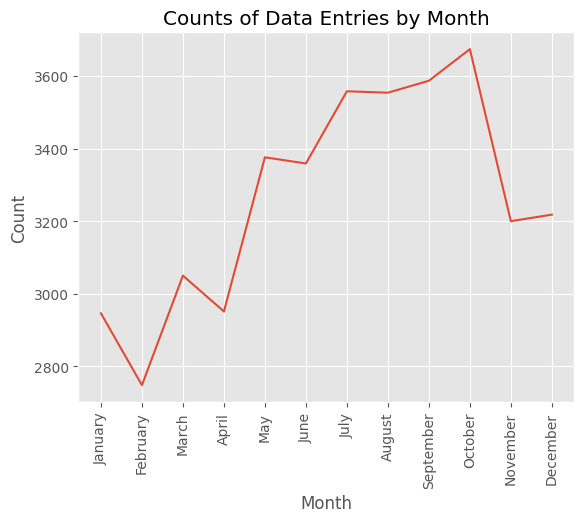

In [25]:
sns.lineplot(x='MONTHNAME', y='Count', data=month_counts)
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Counts of Data Entries by Month')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

plt.show()

# very strange to see this trend, why are there ~1000 more deaths in October compared to Feb?

# As I am from florida, I want to see if this trend is similar in FL

<Axes: xlabel='MONTHNAME'>

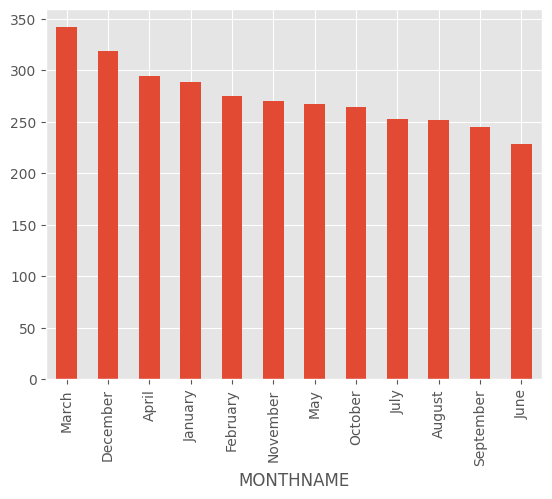

In [26]:
df.query('STATENAME == "Florida"')['MONTHNAME'].value_counts().plot(kind = 'bar')

# --------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------
# PERSON DATAFRAME
# --------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------

### here we will look at the amount of fatal motorcycle crashes, and see how they contibute to overall deaths

In [27]:
try:
    df_person = pd.read_csv('/kaggle/input/fatal-motor-vehicle-crashes-2022-nhsta/FARS2022NationalCSV/person.csv', encoding='ISO-8859-1')
    print("File read successfully with ISO-8859-1 encoding.")
except Exception as e:
    print("Error reading with ISO-8859-1:", e)

File read successfully with ISO-8859-1 encoding.


In [28]:
df_person.shape

(95757, 126)

In [29]:
df_person.head()

,STATE,STATENAME,ST_CASE,VEH_NO,PER_NO,VE_FORMS,COUNTY,MONTH,MONTHNAME,DAY,DAYNAME,HOUR,HOURNAME,MINUTE,MINUTENAME,HARM_EV,HARM_EVNAME,MAN_COLL,MAN_COLLNAME,SCH_BUS,SCH_BUSNAME,MOD_YEAR,MOD_YEARNAME,VPICMAKE,VPICMAKENAME,VPICMODEL,VPICMODELNAME,VPICBODYCLASS,VPICBODYCLASSNAME,MAKE,MAKENAME,BODY_TYP,BODY_TYPNAME,ICFINALBODY,ICFINALBODYNAME,GVWR_FROM,GVWR_FROMNAME,GVWR_TO,GVWR_TONAME,TOW_VEH,TOW_VEHNAME,AGE,AGENAME,SEX,SEXNAME,PER_TYP,PER_TYPNAME,INJ_SEV,INJ_SEVNAME,SEAT_POS,SEAT_POSNAME,REST_USE,REST_USENAME,REST_MIS,REST_MISNAME,HELM_USE,HELM_USENAME,HELM_MIS,HELM_MISNAME,AIR_BAG,AIR_BAGNAME,EJECTION,EJECTIONNAME,EJ_PATH,EJ_PATHNAME,EXTRICAT,EXTRICATNAME,DRINKING,DRINKINGNAME,ALC_STATUS,ALC_STATUSNAME,ATST_TYP,ATST_TYPNAME,ALC_RES,ALC_RESNAME,DRUGS,DRUGSNAME,DSTATUS,DSTATUSNAME,HOSPITAL,HOSPITALNAME,DOA,DOANAME,DEATH_DA,DEATH_DANAME,DEATH_MO,DEATH_MONAME,DEATH_YR,DEATH_YRNAME,DEATH_HR,DEATH_HRNAME,DEATH_MN,DEATH_MNNAME,DEATH_TM,DEATH_TMNAME,LAG_HRS,LAG_HRSNAME,LAG_MINS,LAG_MINSNAME,STR_VEH,LOCATION,LOCATIONNAME,WORK_INJ,WORK_INJNAME,HISPANIC,HISPANICNAME,RUR_URB,RUR_URBNAME,FUNC_SYS,FUNC_SYSNAME,SPEC_USE,SPEC_USENAME,EMER_USE,EMER_USENAME,ROLLOVER,ROLLOVERNAME,IMPACT1,IMPACT1NAME,FIRE_EXP,FIRE_EXPNAME,MAK_MOD,MAK_MODNAME,DEVTYPENAME,DEVMOTORNAME,DEVTYPE,DEVMOTOR
0,1,Alabama,10001,1,1,2,107,1,January,1,1,12,12:00pm-12:59pm,30,30,12,Motor Vehicle In-Transport,7,Sideswipe - Same Direction,0,No,2016.0,2016,483.0,Jeep,1943.0,Wrangler,7.0,Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV),2.0,Jeep / Kaiser-Jeep / Willys- Jeep,14.0,"Compact Utility (Utility Vehicle Categories ""Small"" and ""Midsize"")",0.0,Not Applicable,11.0,"Class 1: 6,000 lbs. or less (2,722 kg or less)",11.0,"Class 1: 6,000 lbs. or less (2,722 kg or less)",0.0,No Trailers,37,37 Years,1,Male,1,Driver of a Motor Vehicle In-Transport,4,Fatal Injury (K),11,"Front Seat, Left Side",20,None Used/Not Applicable,7,None Used/Not Applicable,20,Not Applicable,7,None Used/Not Applicable,1,Deployed- Front,1,Totally Ejected,9,Ejection Path Unknown,0,Not Extricated or Not Applicable,0,No (Alcohol Not Involved),0,Test Not Given,0,Test Not Given,996,Test Not Given,0,No (drugs not involved),8,Not Reported,5,EMS Ground,0,Not Applicable,1,1,1,January,2022,2022,13,13:00-13:59,53,53,1353,1353,1,1,23,23,0,0,Occupant of a Motor Vehicle,0,No,7,Non-Hispanic,1,Rural,3,Principal Arterial - Other,0.0,No Special Use Noted,0.0,Not Applicable,3.0,Rollover,81.0,Right,0.0,No or Not Reported,2403.0,Jeep / Kaiser-Jeep / Willys- Jeep YJ series/Wrangler,NaN,NaN,NaN,NaN
1,1,Alabama,10001,2,1,2,107,1,January,1,1,12,12:00pm-12:59pm,30,30,12,Motor Vehicle In-Transport,7,Sideswipe - Same Direction,0,No,2021.0,2021,498.0,Hyundai,2058.0,Tucson,7.0,Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV),55.0,Hyundai,14.0,"Compact Utility (Utility Vehicle Categories ""Small"" and ""Midsize"")",0.0,Not Applicable,11.0,"Class 1: 6,000 lbs. or less (2,722 kg or less)",11.0,"Class 1: 6,000 lbs. or less (2,722 kg or less)",0.0,No Trailers,58,58 Years,2,Female,1,Driver of a Motor Vehicle In-Transport,0,No Apparent Injury (O),11,"Front Seat, Left Side",3,Shoulder and Lap Belt Used,0,No Indication of Misuse,20,Not Applicable,7,None Used/Not Applicable,20,Not Deployed,0,Not Ejected,0,Ejection Path Not Applicable,0,Not Extricated or Not Applicable,0,No (Alcohol Not Involved),0,Test Not Given,0,Test Not Given,996,Test Not Given,0,No (drugs not involved),0,Test Not Given,0,Not Transported for Treatment,0,Not Applicable,88,Not Applicable (Non-Fatal),88,Not Applicable (Non-Fatal),8888,Not Applicable (Non-fatal),88,Not Applicable (Non-fatal),88,Not Applicable (Non-fatal),8888,Not Applicable (Non-fatal),999,Unknown,99,Unknown,0,0,Occupant of a Motor Vehicle,8,Not Applicable (not a fatality),0,Not A Fatality (not Applicable),1,Rural,3,Principal Arterial - Other,0.0,No Special Use Noted,0.0,Not Applicable,0.0,No Rollover,7.0,7 Clock Point,0.0,No or Not Reported,55402.0,Hyundai Tucson,NaN,NaN,NaN,NaN
2,1,Alabama,10001,2,2,

In [30]:
df_person['ST_CASE'].isna().sum()

0

In [31]:
df_person['ST_CASE'].duplicated().sum()

56536

In [32]:
df_person['SEXNAME'].value_counts().head(2).sum()

93366

In [33]:
df_person['VPICBODYCLASSNAME'].value_counts()

VPICBODYCLASSNAME
Sedan/Saloon                                                                   23075
Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV)                        21434
Pickup                                                                         14220
Truck-Tractor                                                                   3809
Hatchback/Liftback/Notchback                                                    2543
Coupe                                                                           2507
Minivan                                                                         2246
Motorcycle - Sport                                                              1946
Motorcycle - Touring / Sport Touring                                            1682
Truck                                                                           1370
Unknown                                                                         1313
Motorcycle - Custom                            

In [34]:
df_person2 = df_person.drop_duplicates(subset= 'ST_CASE').copy()

df_person2.shape

(39221, 126)

In [35]:
motorcycles = df_person2[df_person2['VPICBODYCLASSNAME'].str.contains('Motorcycle', case = False, na = False)]

motorcycles['VPICBODYCLASSNAME'].value_counts()

VPICBODYCLASSNAME
Motorcycle - Sport                                                 1331
Motorcycle - Touring / Sport Touring                                997
Motorcycle - Custom                                                 590
Motorcycle - Cruiser                                                397
Motorcycle - Street                                                 292
Off-road Vehicle - All Terrain Vehicle (ATV) (Motorcycle-style)     223
Motorcycle - Standard                                               159
Motorcycle - Scooter                                                148
Motorcycle - Dual Sport / Adventure / Supermoto / On/Off-road        96
Motorcycle - Trike                                                   65
Motorcycle - Unknown Body Class                                      62
Motorcycle - Unenclosed Three Wheeled / Open Autocycle               28
Motorcycle - Moped                                                   23
Motorcycle - Small / Minibike                 

In [36]:
motorcycle_deaths = motorcycles['VPICBODYCLASSNAME'].value_counts().sum()

motorcycle_deaths

4425

In [37]:
all_deaths = df_person2.shape[0]

all_deaths

39221

In [38]:
motorcycle_deaths / all_deaths

0.11282221259019402

# wow

# 11% of all fatal crashes from motorcycles, even though they only make up only 3% of all registered vehicles and 0.7% of all vehicle miles traveled in the United State